In [1]:
%matplotlib inline

In [369]:
import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray
import gsw

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 4])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [486]:
file = '../data/goship/selected/p01h_10_00002_ct1.csv'
data = pd.read_csv(file,header=19,skipfooter=1,engine='python')
data = data.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Unnamed: 7','Unnamed: 8','ML/L'])
data.rename(columns={'ITS-90':'tmp','PSS-78':'sal','DBAR':'prs'},inplace=True)

In [487]:
lon0 = 146.3
lat0 = 41.9
data['sal'] = gsw.SA_from_SP(data.sal,data.prs,lon0,lat0)
data['tmp'] = gsw.CT_from_t(data.sal,data.tmp,data.prs)
data['rho'] = gsw.rho(data.sal,data.tmp,data.prs)
data['z'] = gsw.z_from_p(data.prs, lat0)

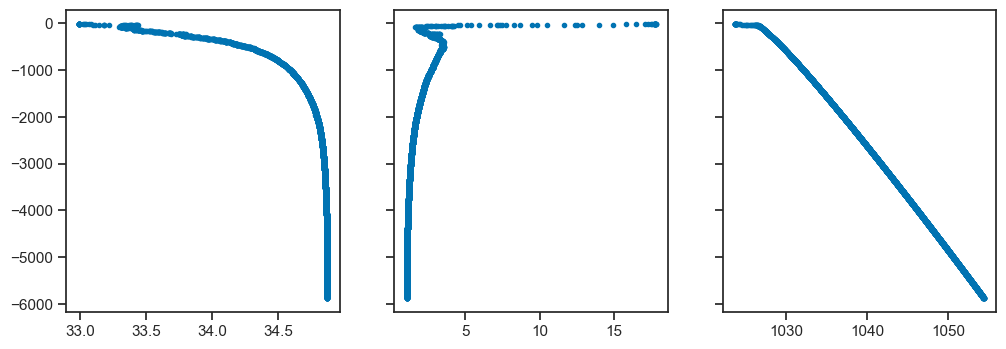

In [488]:
f,ax = plt.subplots(1,3,sharey=True)
ax[0].plot(data.sal,data.z,'.')
ax[1].plot(data.tmp,data.z,'.')
ax[2].plot(data.rho,data.z,'.');

In [489]:
ds = xr.Dataset.from_dataframe(data.set_index('z'))

In [490]:
ds

<xarray.Dataset>
Dimensions:  (z: 5999)
Coordinates:
  * z        (z) float64 -3.969 -4.961 -5.953 ... -5.872e+03 -5.873e+03
Data variables:
    prs      (z) float64 4.0 5.0 6.0 7.0 ... 5.999e+03 6e+03 6.001e+03 6.002e+03
    tmp      (z) float64 17.8 17.79 17.79 17.8 17.8 ... 1.054 1.054 1.054 1.054
    sal      (z) float64 32.99 32.99 32.99 32.99 ... 34.87 34.87 34.87 34.87
    rho      (z) float64 1.024e+03 1.024e+03 1.024e+03 ... 1.054e+03 1.054e+03

In [499]:
rho0 = ds.rho.mean()
g = 9.81
ds['N2'] = -g*ds.dropna(dim='z').rho.differentiate('z')/rho0
# N0 = np.nanmean( np.sqrt(ds.N2) )
N0 = 2.5e-3
ds['N/N0'] = np.sqrt(ds.N2)/N0

In [500]:
np.nanmean( np.sqrt(ds.N2) )

0.006792364293430734

(1e-05, 0.001)

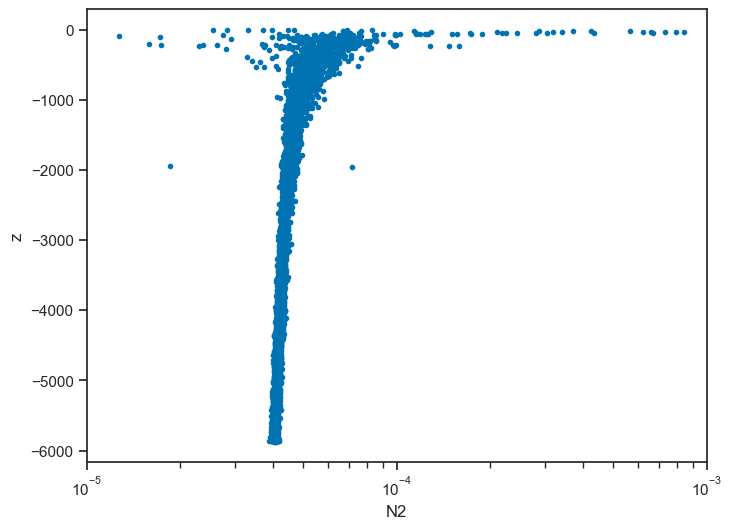

In [501]:
plt.figure(figsize=(8,6))
ds.N2.plot(y='z',lw=0,marker='.')
plt.xscale('log')
plt.xlim(1e-5,1e-3)

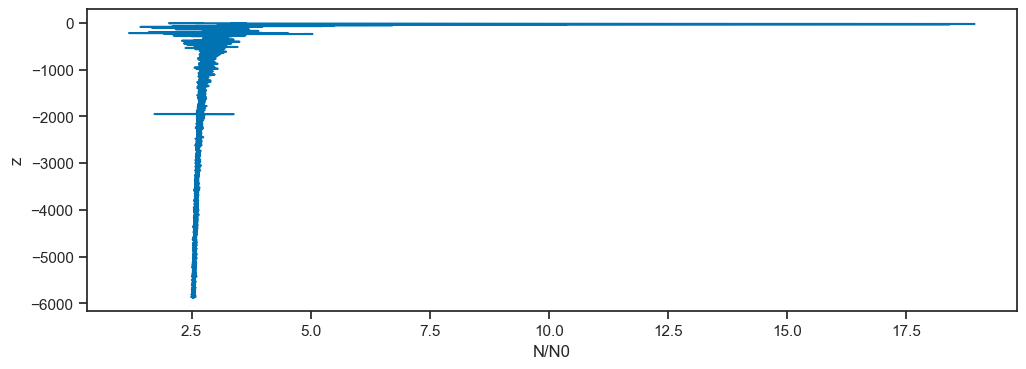

In [502]:
ds['N/N0'].plot(y='z')

In [530]:
dss = ds['N/N0'].dropna('z')
dss = dss.sortby('z', ascending=True)
dss

<xarray.DataArray 'N/N0' (z: 5998)>
array([2.539155, 2.539166, 2.550826, ..., 2.432173, 2.671966, 2.730745])
Coordinates:
  * z        (z) float64 -5.873e+03 -5.872e+03 -5.871e+03 ... -4.961 -3.969

In [531]:
from scipy import integrate,interpolate

In [532]:
zmid = 0.5*( dss.z.values[0:-1] + dss.z.values[1:])
zprime = integrate.cumtrapz(dss,dss['z'])

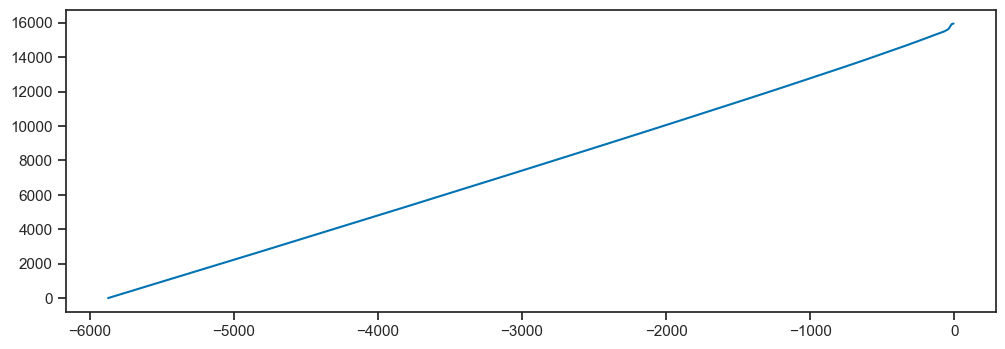

In [533]:
plt.plot(zmid,zprime)